<a href="https://colab.research.google.com/github/nourhanOfTerra/CIFAR-10/blob/main/CIFAR10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CIFAR-10 Classification Model: Convolutional Neural Networks

Source 1: https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c

Source 2: https://www.tensorflow.org/tutorials/images/cnn

Source 3: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

Source 4: https://neptune.ai/blog/keras-metrics


##Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/CIFAR-10')

Mounted at /content/drive


##Importing the necessary libraries

In [2]:
!pip3 install tensorflow==2.7.0
!pip3 install h5py

     |████████████████████████████████| 489.6 MB 21 kB/s 
     |████████████████████████████████| 1.3 MB 55.3 MB/s 
     |████████████████████████████████| 463 kB 63.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0


###General Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

###Model Specific Libraris

In [4]:
import tensorflow as tf
import math
import random
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from time import time
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.models import load_model

##Importing the data from csv files to variables
Note that since we are applying CNNs here, no need for feature extraction. Therefore, we should use the original features as they are.

In [5]:
df_features = pd.read_csv('features.csv')
df_labels = pd.read_csv('labels.csv')

Now converting to numpy arrays as they are easier to deal with in the upcoming functions of the scikit-learn library.

In [6]:
features = df_features.to_numpy()
labels = df_labels.to_numpy()

##Normalizing the features
This would be useful for the activation functions.

In [7]:
scaler = preprocessing.MinMaxScaler()
normalized_features = scaler.fit_transform(features)

##Encoding the labels using one-hot encoding
The reason for that is that there is no real relation between the integer values in the original labels vector and the labels. This might be misleading for the model. One hot encoding might be better in this case.

In [8]:
encoder = OneHotEncoder(sparse = False)
encoded_labels = encoder.fit_transform(labels)

##Reshaping the feature matrix for Tensorflow


In [9]:
reshaped_features = np.reshape(normalized_features, (60000, 3, 32, 32))
transposed_features = reshaped_features.transpose(0, 2, 3, 1)

##Ensuring results reproducibility

In [21]:
#os.environ['TF_DETERMINISTIC_OPS'] = '1'
#SEED = 20
#os.environ['PYTHONHASHSEED'] = str(SEED)
#random.seed(SEED)
#np.random.seed(SEED)
#tf.random.set_seed(SEED)

##Setting the parameters

In [10]:
SIZE = 32                                                                       # Don't Change
BATCHES = 32
EPOCHS = 100
LEARNING_RATE = 0.001
ACTIVATION = 'relu'
FILTER = (3, 3)                                                                 # Don't Change
POOLING = (1, 1)                                                                # Don't Change
OPTIMIZER = 'adam'
LOSS = tf.keras.losses.CategoricalCrossentropy(from_logits = True)              
METRICS = ['accuracy']
TEST = 10000/60000                                                              # Don't Change
VALIDATION = 10000/50000                                                        # Don't Change
INPUT_SHAPE = (32, 32, 3)                                                       # Don't Change
OUTPUTS = 10                                                                    # Don't Change

##Dividing the dataset into training, validation and testing sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(transposed_features, encoded_labels, test_size = TEST)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = VALIDATION)

##Building the model

###Convolutional and MaxPooling layers

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(SIZE, FILTER, activation = ACTIVATION, input_shape = INPUT_SHAPE))             # First convolution layer
model.add(layers.MaxPooling2D(POOLING))                                                                # First MaxPooling
model.add(layers.Conv2D(2*SIZE, FILTER, activation = ACTIVATION))                                      # Second convolution layer
model.add(layers.MaxPooling2D(POOLING))                                                                # Second MaxPooling
model.add(layers.Conv2D(2*SIZE, FILTER, activation = ACTIVATION))
model.add(layers.MaxPooling2D(POOLING))                                                                
model.add(layers.Conv2D(2*SIZE, FILTER, activation = ACTIVATION))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

###Dense layers

In [13]:
model.add(layers.Flatten())                                 # Flattening because input to this layer is 3D Tensor
model.add(layers.Dense(2*SIZE, activation = ACTIVATION))    
model.add(layers.Dense(OUTPUTS))                            # Output layer (10 outputs for 10 classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

##Early Stopping and Model Checkpoint callback functions

In [14]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 10, verbose = 1, min_delta = 0.01)
check_point = ModelCheckpoint('best_cnn.h5', monitor = 'val_accuracy', mode = 'max', save_best_only = True, verbose = 1)
CALLBACKS = [early_stopping, check_point]

##Training

In [ ]:
model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
fitted_model = model.fit(X_train, y_train, batch_size = BATCHES, epochs = EPOCHS, validation_data = (X_val, y_val), callbacks = CALLBACKS)

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 1.5229 - accuracy: 0.4494
Epoch 00001: val_accuracy improved from -inf to 0.55930, saving model to best_cnn.h5
1250/1250 [==============================] - 317s 253ms/step - loss: 1.5229 - accuracy: 0.4494 - val_loss: 1.2400 - val_accuracy: 0.5593
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 1.0944 - accuracy: 0.6133
Epoch 00002: val_accuracy improved from 0.55930 to 0.64810, saving model to best_cnn.h5
1250/1250 [==============================] - 316s 252ms/step - loss: 1.0944 - accuracy: 0.6133 - val_loss: 1.0146 - val_accuracy: 0.6481
Epoch 3/100
1250/1250 [==============================] - ETA: 0s - loss: 0.8850 - accuracy: 0.6876
Epoch 00003: val_accuracy improved from 0.64810 to 0.65410, saving model to best_cnn.h5
1250/1250 [==============================] - 308s 247ms/step - loss: 0.8850 - accuracy: 0.6876 - val_loss: 0.9826 - val_accuracy: 0.6541
Epoch 4/100
1250/1250 [========

##Evaluation of the model on the testing set

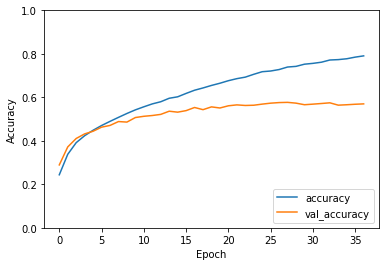

In [105]:
plt.plot(fitted_model.history['accuracy'], label = 'accuracy')
plt.plot(fitted_model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.savefig('Accuracy vs Epochs Trial 7 activation = softmax at the end')

##Loading the best model

In [106]:
best_model = load_model('best_cnn.h5')

##Testing

In [107]:
test_loss, test_acc = best_model.evaluate(X_test,  y_test, verbose=3)
print('Test Accuracy:', test_acc)
y_predicted = best_model.predict(X_test, batch_size = BATCHES, verbose = 1)
confused = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_predicted, axis = 1))
print("\nThe confusion matrix: ")
print(confused)
report = classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predicted, axis = 1))
print("\nThe classification report: ")
print(report)
acc_score = accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_predicted, axis = 1))
print("\nTest Accuracy:", acc_score)

Test Accuracy: 0.5740000009536743
313/313 [==============================] - 3s 9ms/step

The confusion matrix: 
[[465  11 104  12  33   6   6  55 227  45]
 [ 21 697   6  11   5   3  15   4  37 144]
 [ 73   3 361 104 171  65 150  34  32  11]
 [ 24   6 131 235  64 356 104  60  22  23]
 [ 35   3  92  43 543  35  90 138   6   4]
 [  9   4  69 161  50 604  28  68   8   5]
 [ 11   7  72  55  86  19 769   5   1   9]
 [ 22   3  30  24 107  63   5 739   3  12]
 [134  25  32  10   2  10   1   8 763  23]
 [ 58 193  18  24  22   6   9  96  29 564]]

The classification report: 
              precision    recall  f1-score   support

           0       0.55      0.48      0.51       964
           1       0.73      0.74      0.74       943
           2       0.39      0.36      0.38      1004
           3       0.35      0.23      0.28      1025
           4       0.50      0.55      0.52       989
           5       0.52      0.60      0.56      1006
           6       0.65      0.74      0.70     